## Conditional Variational Autoencoder in Keras

This notebook trains a conditional VAE on the MNIST data set using the keras API. It's based on the paper [Learning Structured Output Representation using Deep Conditional Generative Models ](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=2&cad=rja&uact=8&ved=0ahUKEwiamruIr5HVAhXFVj4KHRh0BG4QFggxMAE&url=https%3A%2F%2Fpdfs.semanticscholar.org%2F3f25%2Fe17eb717e5894e0404ea634451332f85d287.pdf&usg=AFQjCNGP9YZk7oDH-pyk_2_V3dAPJEiMbg) and inspired by the code fragments from Agustinus Kristiadi's blog [here](http://wiseodd.github.io/techblog/2016/12/17/conditional-vae/). For a really thorough math review on VAEs, please refer to Agustinus' blog post.

My intent here is just to further my own understanding of how this type of autoencoder is constructed, and then probe the meaning of the variables in the latent space later on.

### Setup
We'll import a numpy and some useful stuff from Keras- namely all of the layers we're planning to use, the `Model` API, the backend (enabling us to directly manipulate tensors), MNIST data, and a few utilities for plotting and training.

In [1]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scipy.misc import imsave
import matplotlib.pyplot as plt

from glob import glob
import cv2

warnings.filterwarnings('ignore')
%pylab inline

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


#### Data import


In [2]:
IMAGE_WIDTH = 28

In [3]:
X_train, Y_train, y_train = [], [], []
for image in glob('train_emnist/*.png'):
    im = cv2.imread(image)
    im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    X_train.append(im[:, IMAGE_WIDTH:])
    y_train.append(im[:, :IMAGE_WIDTH])
    Y_train.append(int(image.split('/')[-1].split('-')[0]))

X_train = np.array(X_train)
Y_train = np.array(Y_train)
y_train = np.array(y_train)

In [4]:
(X_train, y_train, Y_train), (X_test, y_test, Y_test) = (X_train[1000:112600], y_train[1000:112600], Y_train[1000:112600]), (X_train[:1000], y_train[:1000], Y_train[:1000])

#### Reshaping
We have to do two things here:

*1: Properly represent the pixel information contained in **X** to a fully-connected feed forward neural network*

I'm planning on using a fully-connected (dense) layer to look at the MNIST pixel information because 784 pixels (28x28) isn't really that big. We could alternatively do some convolution and retain the information involved in the spatial distribution of the pixels, but in this notebook we'll stick with fully-connected layers. First we'll convert the matrices to 32-bit floating point values and normalize. Then we'll reshape the matrices to make them flat vector respresentations of the 784 pixel values.

In [5]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

*2: Properly represent the label **y***

Encoding the class labels of **y** as the integers they represent makes intuitive sense, but the common loss functions for classification ine keras use cross-entropy and expect one-hot encoded vectors (of dimension *K-1*, where *K* is your number of classes) for class labels rather than just a 1d vector of class names. Luckily, Keras has a built-in utility function to one-hot encode classes.

In [6]:
y_train = y_train.astype('float32') / 255.
y_test = y_test.astype('float32') / 255.

y_train = y_train.reshape((len(y_train), n_pixels))
y_test = y_test.reshape((len(y_test), n_pixels))

#### Hyperparameters
Assign the type of optimizer, batch size, latent-space represeentation size, and number of epochs. We'll also save the widths of the **X** and **Y** matrices for convenience in referencing them further on.

In [7]:
m = 200 # batch size
n_z = 2 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam()


n_x = X_train.shape[1]
n_y = y_train.shape[1]

n_epoch = 100

### The encoder
We'll be using the Keras functional API rather than the sequential because of the slightly more complex structure of the VAE. First we'll explicitly define input layers for **X** and **y**. Keras needs to know their shapes at the input layer, but can infer them later on.

In [8]:
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

Next we'll concatenate the **X** and **y** vectors. It may appear that it would've been simpler to merge the pixel and class label vectors from the beginning (now that they're both 1d) rather than reading them into the graph as separate input layers and concatenating them... but in reality, we need them to remain separate entities so that we can properly calculate our reconstruction error (we aren't asking the autoencoder to reassemble **y** in addition to **X**).

In [9]:
inputs = concat([X, label])

Once we've defined our inputs and merged them within the context of the graph, we'll pass them to a dense layer consisting of the previuosly specified number of neurons (512) and activation function (ReLU). That layer is then connected to layers that produce our mean ($\mu$) and standard deviation ($\log(\sigma)$) for the variational sampling that occurs later.

In [10]:
encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

Next we define a function that adds random normal noise to our sampling process, and call it with a `Lamda` layer. This is really the guts of the **variational** part of this type of method, and you should refer to the blog post mentioned above for a good understanding of why this is happening.

In [11]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

### The latent space
Now that we've built our encoder and defined our sampling function, our latent space (**z**) is easy to define.

First, using our `sample_z` function, we generate a vector of length `n_z` (in this case 2). If this were a normal VAE we could stop here and move on to the decoder, but instead we are going to concatenate our latent **z** respresentation with the same sparse **y** vector that we initially merged to our pixel representation **X** in the input layers. This gives us a 1x12 vector with 3 non-zero values as we move from the latent space to the decoder.


In [12]:
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])

### Decoder
The encoder has hopefully taken the information contained in 784 pixels (plus the class label), and created some vector **z**. The decoding process is the reconstruction from **z** to **X_hat**. Unlike a normal undercomplete autoencoder, we won't stick to a rigid symmetrical funnel-type architecture here. Instead I'll define two dense layers of 512 and 784 neurons that have ReLU and sigmoidal activation functions, respectively.

In [13]:
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

### Defining loss
If you're familiar with autoencoders, you probably understand that they are backpropagated using reconstruction loss. This is a measure of error between the input **X** and the decoded output **X_hat**. In VAEs, our loss is the sum of reconstruction error and the kullback-leibler divergence between our $\mu$ and log-$\sigma$ and the standard normal.

In this notebook I've defined the `vae_loss` function, which we'll use to optimize our model. I've also broken it down into the `KL_loss` and `recon_loss` subcomponents so that we can track these values as metrics during training.

In [14]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
    return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
    return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

### Defining the graphs
First, we can create networks of from the Keras `Model` class by defining the inputs and outputs of our conditional variational autoencoder, as well as the encoder/decoder subcomponents. 

In [15]:
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

### Training
We train the model as a whole, using the `compile` and `fit` methods for the `cvae` object. We'll use the optimizer that we defined previously, our custom `vae_loss`, and we'll also pass the `KL_loss` and `recon_loss` to the `metrics` argument so that they'll be tracked by batch.

For the `fit` method we pass a list of inputs, validation data, the number of epochs, and a callback that stops the model early if validation loss hasn't improved in the past 5 epochs.

In [16]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

In [17]:
# compile and fit
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
                        validation_data = ([X_test, y_test], X_test),
                        callbacks = [EarlyStopping(patience = 5)])

Train on 111600 samples, validate on 1000 samples
Epoch 1/100
111600/111600 [==============================] - 4s 32us/step - loss: 229.0021 - KL_loss: 3.5780 - recon_loss: 225.4240 - val_loss: 212.2639 - val_KL_loss: 4.4756 - val_recon_loss: 207.7883
Epoch 2/100
111600/111600 [==============================] - 2s 22us/step - loss: 205.5983 - KL_loss: 4.7366 - recon_loss: 200.8617 - val_loss: 203.2781 - val_KL_loss: 4.7636 - val_recon_loss: 198.5145
Epoch 3/100
111600/111600 [==============================] - 2s 22us/step - loss: 199.7457 - KL_loss: 4.8247 - recon_loss: 194.9210 - val_loss: 199.7822 - val_KL_loss: 5.0143 - val_recon_loss: 194.7679
Epoch 4/100
111600/111600 [==============================] - 2s 22us/step - loss: 197.0603 - KL_loss: 4.8419 - recon_loss: 192.2184 - val_loss: 198.4373 - val_KL_loss: 5.0024 - val_recon_loss: 193.4349
Epoch 5/100
111600/111600 [==============================] - 2s 22us/step - loss: 195.4470 - KL_loss: 4.8513 - recon_loss: 190.5957 - val_loss

111600/111600 [==============================] - 2s 22us/step - loss: 187.0595 - KL_loss: 5.0849 - recon_loss: 181.9747 - val_loss: 189.3717 - val_KL_loss: 5.1247 - val_recon_loss: 184.2470
Epoch 42/100
111600/111600 [==============================] - 2s 22us/step - loss: 186.9927 - KL_loss: 5.0912 - recon_loss: 181.9015 - val_loss: 189.4724 - val_KL_loss: 5.2077 - val_recon_loss: 184.2647
Epoch 43/100
111600/111600 [==============================] - 2s 22us/step - loss: 186.9449 - KL_loss: 5.0861 - recon_loss: 181.8588 - val_loss: 189.3045 - val_KL_loss: 5.1706 - val_recon_loss: 184.1339
Epoch 44/100
111600/111600 [==============================] - 2s 22us/step - loss: 186.9146 - KL_loss: 5.0859 - recon_loss: 181.8288 - val_loss: 189.1393 - val_KL_loss: 5.0643 - val_recon_loss: 184.0750
Epoch 45/100
111600/111600 [==============================] - 2s 22us/step - loss: 186.8293 - KL_loss: 5.0932 - recon_loss: 181.7361 - val_loss: 189.1780 - val_KL_loss: 5.0858 - val_recon_loss: 184.092

**We now have a trained conditional variational autoencoder. Let's see how it works!**

### Exploring the model
The latent space should hopefully contain some interesting structural information about the digits we're autoencoding. That's the case in any autoencoding network, but in a VAE the spatial arrangement should make more intuitive 'sense' since the noise added to the latent space representation forces the model to create useful respresentations.

#### Generating a latent space representation with the encoder
First let's see concretely what happens when we pass an image and class to the encoder. We can take a look at the first image in the training set:

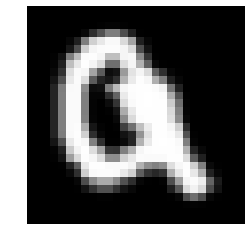

In [18]:
plt.imshow(X_train[0].reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.show()

I think this is supposed to be a 5. Let's make sure.

In [19]:
print(Y_train[0])

36


Now, let's see how this model represents that same digit in the latent space by passing it through the encoder.

In [20]:
encoded_X0 = encoder.predict([X_train[0].reshape((1, 784)), y_train[0].reshape((1, 784))])
print(encoded_X0)

[[-1.0471046   0.22935116]]


The encoder maps the input data from $\mathbb{R}^{794}$ to $\mathbb{R}^2$. In a normal VAE, we'd expect this **z** vector to contain all of the information we need to reconstruct the digit. Therefore, these two numbers would contain information about which digit it is and what the style of the digit is. We'd expect to see a high degree of separation between the digits if we were to plot them. In a conditional VAE, however, we expect something different. Since we append the class label directly to the latent space representation, *our network doesn't need to store any information about which digit it generates in the latent space*. Instead, it can use the latent space to learn other interesting featuers.

In order to illustrate this concept, let's encode our whole training set and see what it looks like.

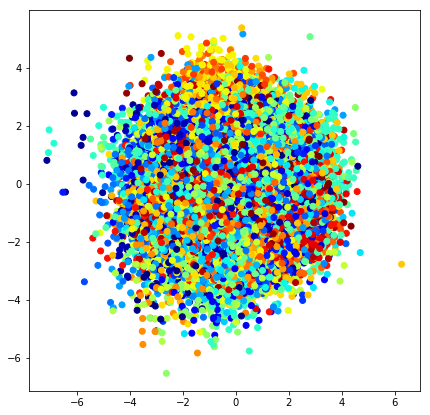

In [21]:
z_train = encoder.predict([X_train, y_train])
encodings= np.asarray(z_train)
encodings = encodings.reshape(X_train.shape[0], n_z)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=Y_train, cmap=plt.cm.jet)
plt.show()

It looks like all of the digits (represented by the different colors) are pretty much layered on top of each other and are distributed approximately bivariate normal. This is what we would expect to happen.

#### Generating a digit
We've now passed images and labels to the encoder and examined the latent space representation. It's clear that the **z** values don't contain useful information about *which* digit is produced... but then what information do they contain?

First, let's just generate a digit. We need to pass a vector to our *decoder* containing everything it needs to create a digit from the latent space. The **z** values are distributed normally with mean 0, so the 'default' setting of them is to be 0. We'll append the label to the **z** values, which is just a one-hot encoding to specify which digit we want to create. So if we want to generate a default 3, we'd pass the encoder something like `[0,0,0,0,0,1,0,0,0,0,0,0]`. I'll define a function to make this easier, and then display the outcome for the digit 3.

In [22]:
def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, n_z:] = digit
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
sample_3 = construct_numvec(y_train[np.random.choice(np.where(Y_train==3)[0])])

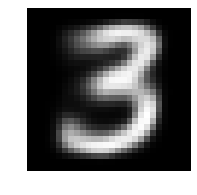

In [23]:
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict(sample_3).reshape(28,28), cmap = plt.cm.gray), axis('off')
plt.show()

#### Exploring the latent space variables
If the label appended dictates which digit will be produced, what does the **z** vector actually do? We know that each z-value is approximately unit-normal. I can choose a digit and plot it as I vary **z**.

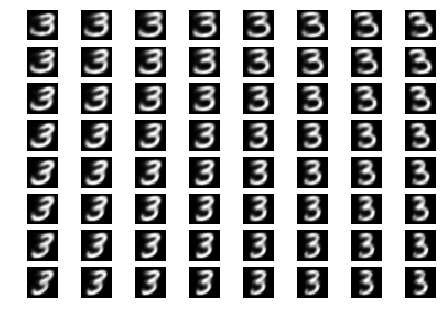

In [24]:
dig = 3
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(y_train[np.random.choice(np.where(Y_train==dig)[0])], z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

As I change **z1** (on the y-axis), the digit style becomes narrower. Varying the value of **z2** (on the x-axis) appears to rotate the digit slightly and elongate the lower portion in relation to the upper portion. There appears to be some interaction between the two values.

The latent variable appears to control the "style" of the digit. Let's see if this transfers to other digits.

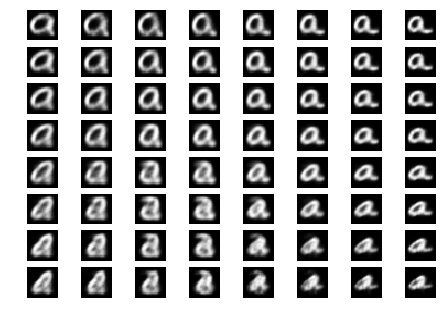

In [25]:
dig = 36
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(y_train[np.random.choice(np.where(Y_train==dig)[0])], z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

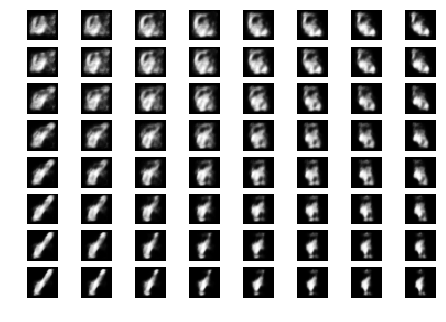

In [26]:
omniglot = cv2.imread('22.png')
omniglot = 255 - cv2.cvtColor(omniglot, cv2.COLOR_RGB2GRAY)

omniglot = cv2.resize(omniglot, (28, 28))

omniglot = omniglot.astype('float32') / 255.
omniglot = omniglot.reshape((n_pixels))

sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(omniglot, z_)
        decoded = decoder.predict(vec)
        subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray), axis('off')
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

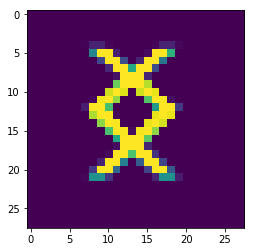

In [27]:
plt.imshow(omniglot.reshape(28, 28))